# Uncovering the Skies: Analyzing British Airways Customer Reviews Through Web Scrapping

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

## Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this project, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import nltk
nltk.download()
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# Downloading the required NLTK packages
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package punkt to C:\Users\RAFLY AULYA RIZKY
[nltk_data]     N\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RAFLY AULYA RIZKY
[nltk_data]     N\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\RAFLY AULYA RIZKY
[nltk_data]     N\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\RAFLY AULYA
[nltk_data]     RIZKY N\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Preprocessing

In [2]:
def format_airline_name(airline_name):
    # Menambahkan tanda hubung di antara kata-kata
    formatted_name = '-'.join(airline_name.split())
    return formatted_name

# UNTUK MASUKIN NAMA AIRLINES NYA, NTAR DI WEBSITE HARUS DI PERINGATIN DULU, 
# SUPAYA NULIS NAMA AIRLINESNYA GAK SALAH 
# CONTOH: air france BETUL,, airfrance SALAH 
# CONTOH: air asia SALAH,, airasia BENAR


airline_name = input('input the airline\'s name:')
output_name = format_airline_name(airline_name)
print(output_name)  # Output: british-airways

british-airways


In [3]:
# base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
base_url = f"https://www.airlinequality.com/airline-reviews/{output_name}"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):
    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [4]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | I am a British Airways Gold ...
1,Not Verified | Another case of reviewing Brit...
2,✅ Trip Verified | On the memorable day of Janu...
3,Not Verified | I did not actually get to fly w...
4,✅ Trip Verified | We had possibly the worse ch...


In [5]:
# set index
df.index = range(1, len(df)+1)

In [6]:
unnecessary_statement1 = '✅ Trip Verified | '
unnecessary_statement2 = 'Not Verified | '
unnecessary_word3 = '✅ Verified Review | '

df.reviews = df.reviews.apply(lambda x: x.replace(unnecessary_statement1, ''))
df.reviews = df.reviews.apply(lambda x: x.replace(unnecessary_statement2, ''))
df.reviews = df.reviews.apply(lambda x: x.replace(unnecessary_word3, ''))
df

,reviews
1,I am a British Airways Gold Guest List member ...
2,Another case of reviewing British Airways fli...
3,"On the memorable day of January 9th, my family..."
4,I did not actually get to fly with BA as they ...
5,We had possibly the worse check-in experience ...
...,...
996,Gatwick to Mauritius. My wife and 2 friends b...
997,"Flew out of Heathrow on 22nd Feb to New York,..."
998,Horrible flight BA from Gatwick to Cape Town ...
999,New York to Venice via London. Staff have bee...


In [8]:
import random 

randcol = random.choice(df['reviews'])
randcol

' I have a booking for March 19th, London Heathrow to Valencia, and BA still show this flight as operating and are not providing any refund option. The BA website was updated on 17 March to state "We’re working closely with the Foreign & Commonwealth Office (FCO) to continue flying, where travel restrictions allow and where it is safe to do so." I then checked the FCO website that was also updated on 17 March and it states: "The Foreign and Commonwealth Office (FCO) advises against all but essential travel to Spain." So it is clear that BA deem it "safe" to fly to Spain despite the FCO statement. I know the airline is suffering, like the rest of UK industry and business, but how can they get away with such deceitful practices. It is clear they are expecting customers to change their booking to the future and keep the funds, and are not complying with the British FCO advisory. Is this actually legal?'

## Data Analysis

In [9]:
def analyze_sentiment(reviews):
    tokens = nltk.word_tokenize(reviews)
    
    tagged_tokens = nltk.pos_tag(tokens)

    lemmatized_words = []
    lemmatizer = nltk.WordNetLemmatizer()
    for word, tag in tagged_tokens:
        tag = tag[0].lower() if tag[0].lower() in ['a', 'r', 'n', 'v'] else 'n'
        lemmatized_words.append(lemmatizer.lemmatize(word, tag))

    stopwords = nltk.corpus.stopwords.words('english')
    clean_words = [word for word in lemmatized_words if word.lower() not in stopwords]

    clean_text = ' '.join(clean_words)

    blob = TextBlob(clean_text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    if polarity > 0:
        sentiment = 'Positive'
    elif polarity < 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    return sentiment, polarity, subjectivity

df[['sentiment', 'polarity', 'subjectivity']] = df['reviews'].apply(analyze_sentiment).apply(pd.Series)

In [10]:
df

,reviews,sentiment,polarity,subjectivity
1,I am a British Airways Gold Guest List member ...,Positive,0.156667,0.478611
2,Another case of reviewing British Airways fli...,Positive,0.150000,0.204762
3,"On the memorable day of January 9th, my family...",Positive,0.198904,0.510526
4,I did not actually get to fly with BA as they ...,Positive,0.266667,0.333333
5,We had possibly the worse check-in experience ...,Negative,-0.030449,0.400321
...,...,...,...,...
996,Gatwick to Mauritius. My wife and 2 friends b...,Negative,-0.126250,0.428750
997,"Flew out of Heathrow on 22nd Feb to New York,...",Positive,0.384091,0.638636
998,Horrible flight BA from Gatwick to Cape Town ...,Negative,-0.212500,0.481250
999,New York to Venice via London. Staff have bee...,Positive,0.020539,0.582043


In [12]:
print('Please select which sentiment reviews you want to display')
review_option = input('positive / negative / neutral?\n')

if review_option == 'Positive':
    positive_reviews = df[df['sentiment'] == 'Positive']
    random_review = np.random.choice(positive_reviews['reviews'])
if review_option == 'Negative':
    negative_reviews = df[df['sentiment'] == 'Negative']
    random_review = np.random.choice(negative_reviews['reviews'])
if review_option == 'Neutral':
    neutral_reviews = df[df['sentiment'] == 'Neutral']
    random_review = np.random.choice(neutral_reviews['reviews'])
    
print(random_review)

Please select which sentiment reviews you want to display
Turned up 3.5 hours in advance, Terminal 5 at London Heathrow was already carnage, 100s of people trying to check in, only 5 desks manned. Long queues at security due to only 4 lines open. People stressed, pushing, shouting, and flight delayed by 2 hours, according to pilot delay due to suitcases all needing to be loaded. Missed connecting flight in Doha, 12 hours wait til next one. Received a voucher, approx £6 for the whole day. Arrived 1 day later, my suitcase didn’t arrive with me. Filed a claim at the desk, for 5 days no update, no information, no offer of compensation and no solution offer. I now have a spoilt holiday, many personal belongings are gone, xmas gifts missing, extensive expenses I don’t know if I will be reimbursed. Beware with BA, expect low level or zero customer service, old planes, and zero help if anything goes wrong or missing. I will personally avoid BA in future at all costs.


## Sentiment Analysis

In [11]:
print('Please select which sentiment reviews you want to analyze')
review_option = input('Positive / Negative / Neutral?\n')

sentiment_reviews = df[df['sentiment'] == review_option]
sentiment_reviews = sentiment_reviews['reviews'].tolist()
sentiment_reviews = ' '.join(sentiment_reviews)
text = sentiment_reviews
text

Please select which sentiment reviews you want to analyze


' Booked a very special holiday for me and my partner, September arrived and we were on our way to lovely South of France, Booked Business Class for us both to start the holiday right. As we were checking I was told the flight was over booked and our seats wouldn\'t print onto the ticket for some reason. We had already made sure the seats were booked when we had booked the flights nearly a year prior to going. Unfortunately when we arrived at the gate we were then told we would no longer be sat together and one of us would in fact have to go into economy. My girlfriend is an extremely nervous flyer and so had to take extra tablets to remain calm, She didn\'t have any food which we had pre booked also and she was sat right down the bottom end of the flight. We were held at the gate with another 4 or 5 couples all in the same predicament all due to the lovely money grabbing British Airways over booking the flight. They ended up refusing passengers in the end and even had people sat on th

In [12]:
text = text.lower()
text = re.sub(r'\d+','', text)

In [13]:
text = text.translate(str.maketrans('', '', string.punctuation))
text

' booked a very special holiday for me and my partner september arrived and we were on our way to lovely south of france booked business class for us both to start the holiday right as we were checking i was told the flight was over booked and our seats wouldnt print onto the ticket for some reason we had already made sure the seats were booked when we had booked the flights nearly a year prior to going unfortunately when we arrived at the gate we were then told we would no longer be sat together and one of us would in fact have to go into economy my girlfriend is an extremely nervous flyer and so had to take extra tablets to remain calm she didnt have any food which we had pre booked also and she was sat right down the bottom end of the flight we were held at the gate with another  or  couples all in the same predicament all due to the lovely money grabbing british airways over booking the flight they ended up refusing passengers in the end and even had people sat on the fold down cha

In [14]:
tokens = [word for word in text.split()]

# nltk.download()
clean_tokens = tokens[:]
for token in tokens:
    if token in stopwords.words('english'):
        clean_tokens.remove(token)

In [18]:
freq = nltk.FreqDist(clean_tokens)
for key, val in freq.items():
    print(str(key), ':', str(val))

booked : 138
special : 21
holiday : 36
partner : 15
september : 9
arrived : 110
way : 103
lovely : 25
south : 21
france : 11
business : 258
class : 276
us : 243
start : 22
right : 35
checking : 15
told : 155
flight : 1311
seats : 281
wouldnt : 10
print : 4
onto : 33
ticket : 72
reason : 30
already : 31
made : 123
sure : 38
flights : 187
nearly : 15
year : 42
prior : 21
going : 65
unfortunately : 35
gate : 100
would : 282
longer : 30
sat : 35
together : 29
one : 286
fact : 20
go : 77
economy : 207
girlfriend : 1
extremely : 30
nervous : 5
flyer : 13
take : 86
extra : 57
tablets : 1
remain : 5
calm : 7
didnt : 59
food : 339
pre : 23
also : 125
bottom : 10
end : 31
held : 7
another : 112
couples : 1
predicament : 2
due : 100
money : 66
grabbing : 1
british : 268
airways : 266
booking : 87
ended : 27
refusing : 4
passengers : 142
even : 157
people : 88
fold : 1
chairs : 2
toilet : 20
area : 25
eventually : 26
late : 91
waiting : 47
luggage : 96
come : 38
airtags : 1
stated : 10
cases : 10


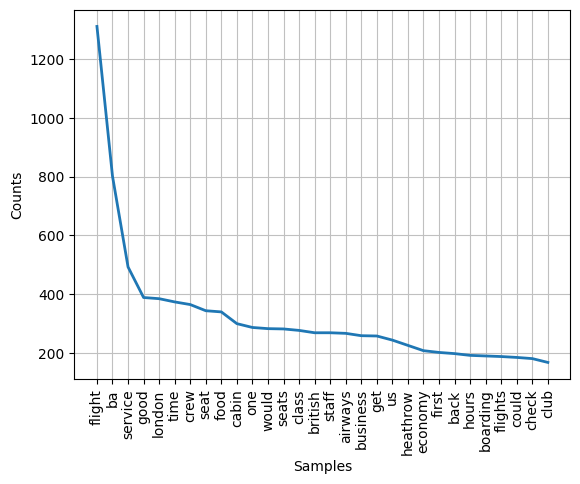

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [16]:
freq.plot(30)

In [21]:
print('above is the result of the', review_option, 'sentiment!')

above is the result of the Positive sentiment!


## Data Visualization

['booked', 'special', 'holiday', 'partner', 'september', 'arrived', 'way', 'lovely', 'south', 'france', 'business', 'class', 'us', 'start', 'right', 'checking', 'told', 'flight', 'seats', 'wouldnt', 'print', 'onto', 'ticket', 'reason', 'already', 'made', 'sure', 'flights', 'nearly', 'year', 'prior', 'going', 'unfortunately', 'gate', 'would', 'longer', 'sat', 'together', 'one', 'fact', 'go', 'economy', 'girlfriend', 'extremely', 'nervous', 'flyer', 'take', 'extra', 'tablets', 'remain', 'calm', 'didnt', 'food', 'pre', 'also', 'bottom', 'end', 'held', 'another', 'couples', 'predicament', 'due', 'money', 'grabbing', 'british', 'airways', 'booking', 'ended', 'refusing', 'passengers', 'even', 'people', 'fold', 'chairs', 'toilet', 'area', 'eventually', 'late', 'waiting', 'luggage', 'come', 'airtags', 'stated', 'cases', 'still', 'heathrow', 'wait', 'days', 'point', 'ruined', 'absolutely', 'shocking', 'couldnt', 'speak', 'anyone', 'phone', 'numbers', 'use', 'felt', 'stranded', 'foreign', 'count

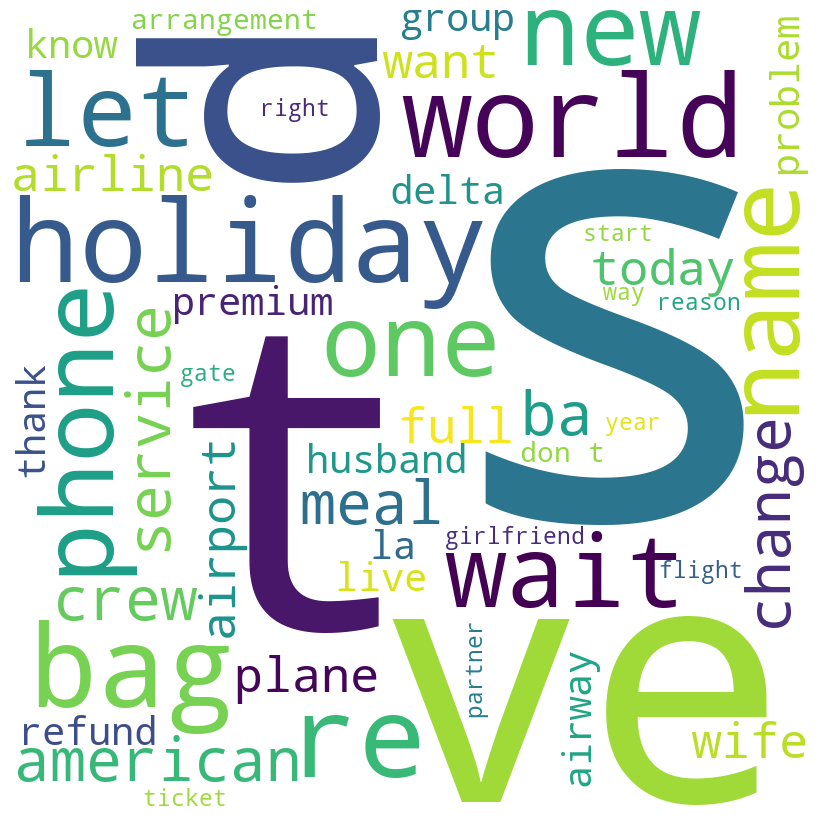

In [35]:
lis = []
freq = nltk.FreqDist(clean_tokens)
for key in freq.items():
    lis.append(str(key[0]))

print(lis)
print('==================\n')

stopwords= set(STOPWORDS)
wordcloud = WordCloud(width=800, height=800,
                      background_color='white', stopwords=stopwords,
                      max_words=50,
                      min_font_size=10).generate(' '.join(lis))

plt.figure(figsize= (8,8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

In [22]:
total_positive = df['sentiment'] == 'Positive'
total_negative = df['sentiment'] == 'Negative'
total_neutral = df['sentiment'] == 'Neutral'

print('total positive sentiments:', total_positive.sum())
print('total negative sentiments:', total_negative.sum())
print('total neutral sentiments:', total_neutral.sum())

total positive sentiments: 674
total negative sentiments: 312
total neutral sentiments: 14


Text(0.5, 1.0, 'Sentiment across Subjectivity')

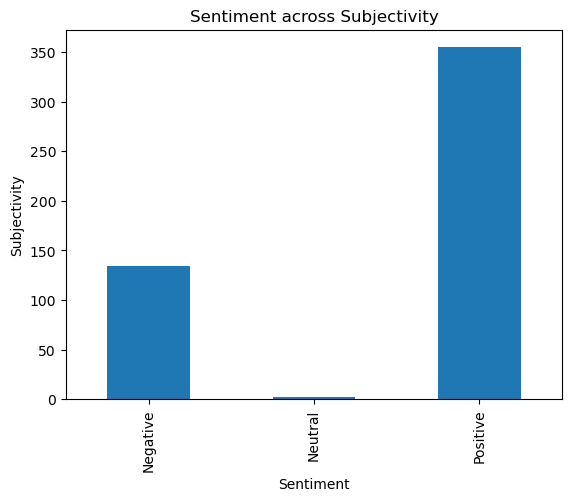

In [40]:
# Visualization of Sentiment across Polarity
# the "Positive" sentiment has the most than the Negative and Neutral

tipe_subjectivity = df.groupby(['sentiment']).sum()['subjectivity']
tipe_subjectivity.plot(kind='bar')
plt.ylabel('Subjectivity')
plt.xlabel('Sentiment')
plt.title('Sentiment across Subjectivity')

[Text(0.5, 0, 'Sentiment'),
 Text(0, 0.5, 'Subjectivity score'),
 Text(0.5, 1.0, 'Box Plot On Sentiment Across Subjectivity')]

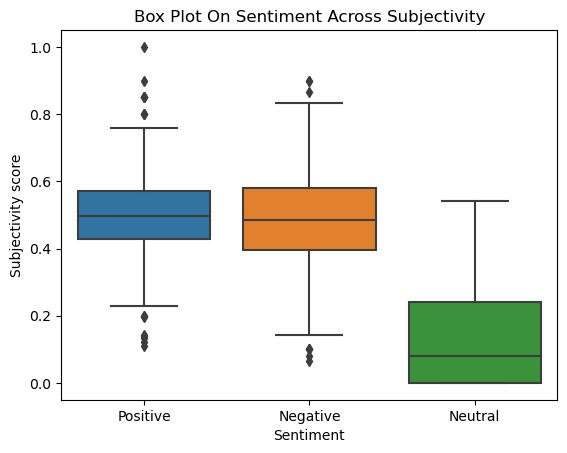

In [41]:
fig,axes = plt.subplots()
sn.boxplot(data=df,y="subjectivity",x="sentiment",orient="v")
axes.set(xlabel='Sentiment', ylabel='Subjectivity score',title="Box Plot On Sentiment Across Subjectivity")


[Text(0.5, 0, 'Sentiment'),
 Text(0, 0.5, 'Polarity score'),
 Text(0.5, 1.0, 'Box Plot On Sentiment Across Polarity')]

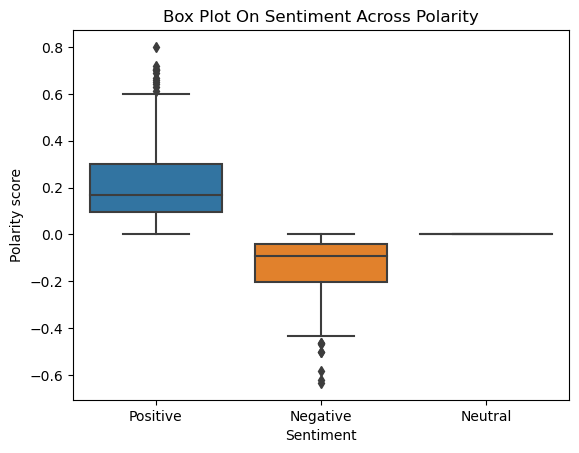

In [42]:
fig,axes = plt.subplots()
sn.boxplot(data=df,y="polarity",x="sentiment",orient="v")
axes.set(xlabel='Sentiment', ylabel='Polarity score',title="Box Plot On Sentiment Across Polarity")

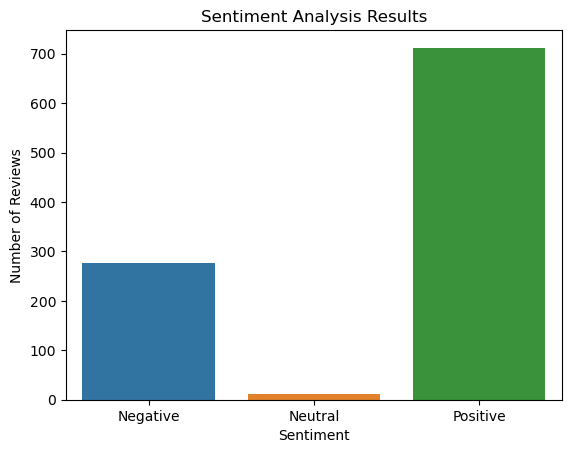

In [43]:
sentiment_counts = df.groupby('sentiment')['reviews'].count()

sn.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Analysis Results')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

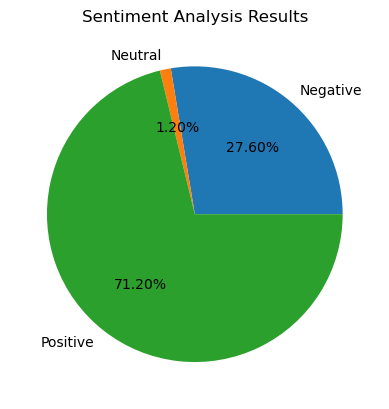

In [44]:
sentiment_counts = df.groupby('sentiment')['reviews'].count()

plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.2f%%')
plt.title('Sentiment Analysis Results')
plt.show()

In [45]:
df

,reviews,sentiment,polarity,subjectivity
1,Food was lousy. Who ever is planning the Asia...,Positive,0.006250,0.338333
2,Had the worst experience. The flight from Lond...,Negative,-0.175000,0.600000
3,The ground staff were not helpful. Felt like ...,Positive,0.133333,0.266667
4,Second time BA Premium Economy in a newer air...,Positive,0.402917,0.673333
5,They changed our Flights from Brussels to Lon...,Negative,-0.108333,0.458333
...,...,...,...,...
996,Delhi to London. Having read many negative re...,Positive,0.109375,0.366377
997,When you travel British Airways its like you a...,Positive,0.200570,0.491791
998,British Airways gets plenty of well deserved ...,Positive,0.352273,0.522727
999,BA First Class is not even that any more. Sta...,Positive,0.118074,0.477039


In [46]:
df.to_csv("data/BA_reviews.csv")